In [1]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, r2_score

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [2]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
wind = 'windmill_generated_power(kW/h)'
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [3]:
train.dtypes

tracking_id                        object
datetime                           object
wind_speed(m/s)                   float64
atmospheric_temperature(°C)       float64
shaft_temperature(°C)             float64
blades_angle(°)                   float64
gearbox_temperature(°C)           float64
engine_temperature(°C)            float64
motor_torque(N-m)                 float64
generator_temperature(°C)         float64
atmospheric_pressure(Pascal)      float64
area_temperature(°C)              float64
windmill_body_temperature(°C)     float64
wind_direction(°)                 float64
resistance(ohm)                   float64
rotor_torque(N-m)                 float64
turbine_status                     object
cloud_level                        object
blade_length(m)                   float64
blade_breadth(m)                  float64
windmill_height(m)                float64
windmill_generated_power(kW/h)    float64
dtype: object

# Deal with NaN Values:

In [4]:
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

### Remove rows with Null Targets

In [5]:
train = train[~train[wind].isnull()]
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    271
atmospheric_temperature(°C)       3422
shaft_temperature(°C)                2
blades_angle(°)                    212
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2690
area_temperature(°C)                 0
windmill_body_temperature(°C)     2352
wind_direction(°)                 5058
resistance(ohm)                      1
rotor_torque(N-m)                  567
turbine_status                    1747
cloud_level                        272
blade_length(m)                   5057
blade_breadth(m)                     0
windmill_height(m)                 538
windmill_generated_power(kW/h)       0
dtype: int64

### Categorical Features

In [6]:
# Function to impute most occured category and add importance vairable
def impute_categorical(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that vairable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [7]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(train, c)
    
# train[['turbine_status','turbine_status_Imputed','cloud_level','cloud_level_Imputed']].head(10)

### Numerical

In [8]:
train.columns

Index(['tracking_id', 'datetime', 'wind_speed(m/s)',
       'atmospheric_temperature(°C)', 'shaft_temperature(°C)',
       'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'motor_torque(N-m)', 'generator_temperature(°C)',
       'atmospheric_pressure(Pascal)', 'area_temperature(°C)',
       'windmill_body_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'turbine_status', 'cloud_level', 'blade_length(m)',
       'blade_breadth(m)', 'windmill_height(m)',
       'windmill_generated_power(kW/h)', 'turbine_status_Imputed',
       'cloud_level_Imputed'],
      dtype='object')

In [9]:
import datawig

def impute_any(output_column):
    df_train, df_test = datawig.utils.random_split(train)

    #Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=['tracking_id', 'datetime', 'wind_speed(m/s)', 'shaft_temperature(°C)', 'blades_angle(°)',\
                       'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)',\
                       'area_temperature(°C)', 'resistance(ohm)', 'rotor_torque(N-m)', 'turbine_status', 'cloud_level',\
                       'blade_length(m)', 'windmill_height(m)'], # column(s) containing information about the column we want to impute
        output_column= output_column, # the column we'd like to impute values for
        output_path = 'imputer_model' # stores model data and metrics
        )

    #Fit an imputer model on the train data
    imputer.fit(train_df=df_train, num_epochs=50)

    #Impute missing values and return original dataframe with predictions
    imputed = imputer.predict(df_test)
    return imputed
# w = impute_any('wind_speed(m/s)')

In [10]:
for i in train.columns:
    if train[i].isnull().sum()>0:
        mean = train[i].mean()
        train[i].replace(np.nan, mean, inplace=True)

In [11]:

train.shape

(27993, 24)

In [12]:
train.isnull().sum()

tracking_id                       0
datetime                          0
wind_speed(m/s)                   0
atmospheric_temperature(°C)       0
shaft_temperature(°C)             0
blades_angle(°)                   0
gearbox_temperature(°C)           0
engine_temperature(°C)            0
motor_torque(N-m)                 0
generator_temperature(°C)         0
atmospheric_pressure(Pascal)      0
area_temperature(°C)              0
windmill_body_temperature(°C)     0
wind_direction(°)                 0
resistance(ohm)                   0
rotor_torque(N-m)                 0
turbine_status                    0
cloud_level                       0
blade_length(m)                   0
blade_breadth(m)                  0
windmill_height(m)                0
windmill_generated_power(kW/h)    0
turbine_status_Imputed            0
cloud_level_Imputed               0
dtype: int64

In [13]:
train

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_Imputed,cloud_level_Imputed
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,20.767246,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521,0,0
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,20.767246,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275,0,0
2,WM_39146,2019-09-14 14:03:20,95.484724,0.371184,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342,0,0
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,Low,4.857385,0.367140,24.287767,14.851089,0,1
4,WM_21521,2019-05-04 03:13:20,10.722890,0.371184,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,2.248762,0.453374,27.971650,3.519074,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,WM_7814,2019-01-02 02:43:20,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,90.898875,19428.725079,45.429230,44.242269,536.153413,1980.861921,45.909054,BB,Medium,2.774335,0.418299,24.590801,9.587934,0,0
28196,WM_32512,2019-07-26 12:53:20,94.196738,24.034329,42.068979,-99.000000,44.285153,43.487939,2207.882276,72.244645,16596.485400,25.142681,43.616412,354.239825,1712.840457,36.974913,BB,Low,-3.250989,0.461531,26.051604,4.522195,0,0
28197,WM_5193,2018-12-12 02:13:20,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,94.814637,19083.881449,45.129442,43.576510,534.209913,1951.728713,88.319152,D,Medium,2.248762,0.380264,28.533850,11.096599,0,0
28198,WM_12173,2019-02-03 19:13:20,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,90.144418,18360.785707,45.603927,44.973415,568.504898,1968.917692,47.562627,BCB,Low,3.001855,0.346447,47.747269,9.373239,0,0


## Distribution

In [14]:
# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind], color="b");
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)
# plt.show()

In [15]:
# # log(1+x) transform
# train[wind] = np.log1p(train[wind])

# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind] , fit=norm, color="b");

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train[wind])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)

# plt.show()

In [16]:
train[wind]

0         6.766521
1         5.966275
2         2.874342
3        14.851089
4         3.519074
           ...    
28195     9.587934
28196     4.522195
28197    11.096599
28198     9.373239
28199     2.860342
Name: windmill_generated_power(kW/h), Length: 27993, dtype: float64

## Outliers

In [17]:
# def cap_data(df):
#     for col in df.columns:
#         if (df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']) and (col != wind):
#             print("capping the ",col)
#             percentiles = df[col].quantile([0.01,0.99]).values
#             df[col][df[col] <= percentiles[0]] = percentiles[0]
#             df[col][df[col] >= percentiles[1]] = percentiles[1]
#         else:
#             df[col]=df[col]
#     return df

# train = cap_data(train)
# train

## Numerical Values

In [18]:
train.corr()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_Imputed,cloud_level_Imputed
wind_speed(m/s),1.000000,0.049227,0.038410,-0.003567,0.015879,0.153854,0.376057,0.425627,-0.114826,0.196648,0.026874,0.040341,0.235872,0.151219,0.006977,0.003783,-0.011966,0.062433,0.003368,0.003814
atmospheric_temperature(°C),0.049227,1.000000,0.010445,0.006981,0.005582,0.048013,0.089830,0.110769,-0.020482,0.068459,0.007780,0.015902,0.057513,0.041463,0.000510,0.003989,0.001061,-0.000944,-0.004282,-0.004108
shaft_temperature(°C),0.038410,0.010445,1.000000,-0.009828,0.029929,0.204228,0.071005,0.074470,-0.017036,0.088066,0.018291,0.018711,0.032149,0.027626,0.000255,-0.005419,-0.008773,0.046550,0.005582,-0.006541
blades_angle(°),-0.003567,0.006981,-0.009828,1.000000,-0.024936,-0.064863,-0.137669,-0.044039,0.009047,-0.075954,0.002785,-0.025434,-0.032951,-0.048308,-0.007979,-0.060519,0.003536,-0.154166,0.008347,-0.002990
gearbox_temperature(°C),0.015879,0.005582,0.029929,-0.024936,1.000000,0.132466,0.044952,0.044947,-0.008553,0.058131,0.016616,0.025554,0.020389,0.016132,-0.002523,0.011011,0.003095,0.053191,-0.000869,0.001054
engine_temperature(°C),0.153854,0.048013,0.204228,-0.064863,0.132466,1.000000,0.351982,0.360406,-0.058502,0.338099,0.086002,0.129595,0.208158,0.137241,-0.006628,0.011528,-0.011919,0.272495,-0.009371,-0.005568
motor_torque(N-m),0.376057,0.089830,0.071005,-0.137669,0.044952,0.351982,1.000000,0.934848,-0.204984,0.468481,0.026743,0.187357,0.512895,0.387652,0.003927,0.053215,0.000128,0.505169,-0.009989,0.000654
generator_temperature(°C),0.425627,0.110769,0.074470,-0.044039,0.044947,0.360406,0.934848,1.000000,-0.227929,0.510248,0.034705,0.187039,0.539048,0.369033,0.004249,0.017883,-0.001516,0.391658,-0.012693,-0.000800
atmospheric_pressure(Pascal),-0.114826,-0.020482,-0.017036,0.009047,-0.008553,-0.058502,-0.204984,-0.227929,1.000000,-0.085954,-0.007685,-0.025461,-0.122427,-0.088539,0.004934,0.004621,0.002684,-0.012633,0.012444,-0.002586
area_temperature(°C),0.196648,0.068459,0.088066,-0.075954,0.058131,0.338099,0.468481,0.510248,-0.085954,1.000000,0.048913,0.176400,0.266040,0.183230,-0.000158,0.022334,-0.005789,0.384564,-0.008710,-0.002145


In [19]:
from scipy import stats

pearson_p = []
for i in train.columns:
    if train[i].dtypes!='O':
        pearson_coef, p_value = stats.pearsonr(train[i], train[wind])
        pearson_p.append([i, pearson_coef, p_value])
pearson_p_df = pd.DataFrame(pearson_p, columns=['Numerical Features', 'Pearson Coefficient', 'p-Value']) 

In [20]:
pearson_p_final = []
for i in range(20):
    if pearson_p_df.loc[i, 'p-Value'] < 0.001:
        pearson_p_final.append(pearson_p_df.loc[i, 'Numerical Features'])
pearson_p_final

['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)',
 'windmill_generated_power(kW/h)']

## Categorical Variables:

<AxesSubplot:xlabel='turbine_status', ylabel='windmill_generated_power(kW/h)'>

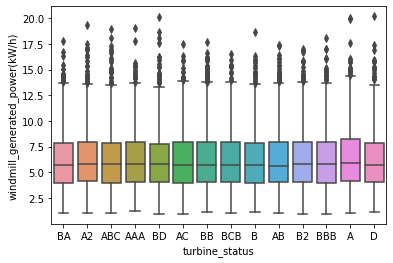

In [21]:
sns.boxplot(train['turbine_status'], train[wind])

<AxesSubplot:xlabel='cloud_level', ylabel='windmill_generated_power(kW/h)'>

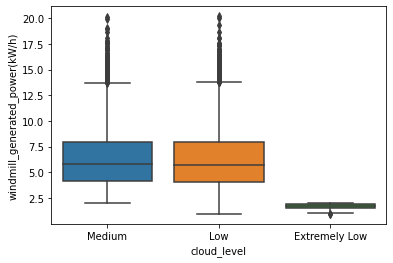

In [22]:
sns.boxplot(train['cloud_level'], train[wind])

In [23]:
cat_group = train[['turbine_status', 'cloud_level', wind]]
cat_group

,turbine_status,cloud_level,windmill_generated_power(kW/h)
0,BA,Medium,6.766521
1,A2,Medium,5.966275
2,ABC,Medium,2.874342
3,ABC,Low,14.851089
4,AAA,Medium,3.519074
...,...,...,...
28195,BB,Medium,9.587934
28196,BB,Low,4.522195
28197,D,Medium,11.096599
28198,BCB,Low,9.373239


In [24]:
cat_group = cat_group.groupby(['cloud_level', 'turbine_status'], as_index=False).mean()
cat_group

,cloud_level,turbine_status,windmill_generated_power(kW/h)
0,Extremely Low,A,1.710368
1,Extremely Low,A2,1.755520
2,Extremely Low,AAA,1.730177
3,Extremely Low,AB,1.733334
4,Extremely Low,ABC,1.638537
5,Extremely Low,AC,1.666935
6,Extremely Low,B,1.674940
7,Extremely Low,B2,1.663634
8,Extremely Low,BA,1.639056
9,Extremely Low,BB,1.731601


In [25]:
grouped_pivot = cat_group.pivot(index='cloud_level',columns='turbine_status')
grouped_pivot

windmill_generated_power(kW/h)                                \
turbine_status                              A        A2       AAA        AB   
cloud_level                                                                   
Extremely Low                        1.710368  1.755520  1.730177  1.733334   
Low                                  6.243275  6.270308  6.181047  6.141169   
Medium                               6.420690  6.219418  6.274094  6.146868   

                                                                            \
turbine_status       ABC        AC         B        B2        BA        BB   
cloud_level                                                                  
Extremely Low   1.638537  1.666935  1.674940  1.663634  1.639056  1.731601   
Low             6.181217  6.143237  6.026146  6.208499  6.179936  6.076956   
Medium          6.107203  6.200777  6.170029  6.276000  6.049994  6.269644   

                                                        
turbine_status       BBB       BCB        BD         D  
cloud_level                                             
Extremely Low   1.720375  1.637298  1.750539  1.659950  
Low             6.059358  6.159323  6.082320  6.013260  
Medium          6.252804  6.174966  6.174176  6.309857

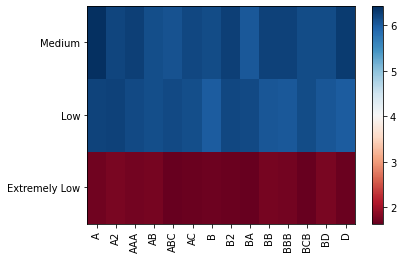

In [26]:
fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

### ANOVA

In [27]:
cat_group2=cat_group[['turbine_status', wind]].groupby(['turbine_status'])
cat_group2.head(1)

,turbine_status,windmill_generated_power(kW/h)
0,A,1.710368
1,A2,1.755520
2,AAA,1.730177
3,AB,1.733334
4,ABC,1.638537
5,AC,1.666935
6,B,1.674940
7,B2,1.663634
8,BA,1.639056
9,BB,1.731601


In [28]:
# turbine_status
f_val, p_val = stats.f_oneway(cat_group2.get_group('A')[wind], cat_group2.get_group('A2')[wind],\
                              cat_group2.get_group('AAA')[wind], cat_group2.get_group('AB')[wind],\
                              cat_group2.get_group('ABC')[wind], cat_group2.get_group('AC')[wind],\
                              cat_group2.get_group('B')[wind], cat_group2.get_group('B2')[wind],\
                              cat_group2.get_group('B2')[wind], cat_group2.get_group('BA')[wind],\
                              cat_group2.get_group('BB')[wind], cat_group2.get_group('BBB')[wind],\
                              cat_group2.get_group('BCB')[wind], cat_group2.get_group('BD')[wind],\
                              cat_group2.get_group('D')[wind])  
 
print( "ANOVA for turbine_status: F=", f_val, ", P =", p_val)

ANOVA for turbine_status: F= 0.000975314905031342 , P = 0.9999999999999999


In [29]:
cat_group3=cat_group[['cloud_level', wind]].groupby(['cloud_level'])
cat_group3.head(1)

,cloud_level,windmill_generated_power(kW/h)
0,Extremely Low,1.710368
14,Low,6.243275
28,Medium,6.420690


In [30]:
# cloud_level
f_val, p_val = stats.f_oneway(cat_group3.get_group('Extremely Low')[wind], cat_group3.get_group('Low')[wind],\
                              cat_group3.get_group('Medium')[wind])  
 
print( "ANOVA for cloud_level: F=", f_val, ", P =", p_val)

ANOVA for cloud_level: F= 16871.07733861549 , P = 5.207236215638991e-58


### So important variables we derived:
#### Numerical:
- wind_speed(m/s)
- haft_temperature(°C)
- blades_angle(°)
- gearbox_temperature(°C)
- engine_temperature(°C)
- motor_torque(N-m)
- generator_temperature(°C)
- area_temperature(°C)
- wind_direction(°)
- resistance(ohm)
- rotor_torque(N-m)
- blade_breadth(m)

#### Categorical
- cloud_level

In [31]:
from sklearn.model_selection import train_test_split
X = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train.shape, X_test.shape

((19595, 21), (8398, 21))

# Encoding

In [32]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['turbine_status', 'cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
10587,91.631751,17.475524,-6.053756,-99.000000,43.570172,40.871759,2048.311825,72.328688,16573.218014,26.413834,40.794926,295.869280,1697.448009,33.479618,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.514712,0.310774,26.070573,0,0
8629,93.674332,20.441598,40.693269,-99.000000,41.778787,43.065791,1087.941429,68.316584,-594834.627007,33.510627,43.041766,524.463347,1662.656181,20.827383,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.448837,0.378873,24.968575,0,0
7065,15.080719,-99.000000,15.197415,-0.307106,16.024006,11.853642,767.486426,38.880344,119242.329458,24.176327,20.767246,280.109871,1217.345249,12.020366,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.353452,0.433982,27.566085,0,0
6301,19.000450,14.396865,44.572377,-0.909147,54.833319,45.716676,793.695909,39.753432,121516.053960,27.908487,-99.000000,306.721006,-99.000000,13.954682,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.013308,0.405832,26.885656,0,0
21145,-186.409024,10.830689,44.640474,-1.114691,42.587215,44.824588,839.215178,39.846920,116264.280714,26.100918,-99.000000,226.837541,1278.058555,14.944096,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,4.803434,0.388273,25.711428,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13210,-107.206822,14.190797,80.688395,-0.692205,137.459567,43.921804,929.826193,42.362351,118426.832893,32.415978,20.767246,232.455409,1420.695555,16.786307,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3.385628,0.407371,26.490003,1,0
19784,94.146353,17.551073,45.146921,9.648162,48.821965,45.241926,2802.511942,92.887576,18847.194888,39.858219,43.560988,499.761898,1975.706079,47.059900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2.357959,0.335699,27.043789,0,0
9910,41.308615,11.860592,45.693220,11.938051,49.468022,42.891585,934.817779,47.127975,141413.343409,36.924496,45.172467,516.914848,1465.555896,18.252104,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2.348490,0.445592,25.164745,1,0
10869,95.722664,26.078089,41.864851,38.798129,39.429732,42.490011,1141.501484,66.925160,16402.040513,33.423691,45.294931,106.899949,1663.606364,-53.173383,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,3.816595,0.383892,25.358264,0,0


In [33]:
X_train.shape, X_test.shape

((19595, 36), (8398, 36))

# Feature Scaling

In [34]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [35]:
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,-0.021843,0.147263,-12.320445,-15.168476,0.061803,-0.813227,0.010607,0.042860,-0.022065,-0.559358,-0.072121,0.069263,0.033726,0.070159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.328199,-0.864337,0.055899,0.0,0.0
1,0.005813,0.280693,-0.740335,-15.168476,-0.278838,-0.140720,-0.593762,-0.063745,-6.159816,0.089090,0.023209,2.770885,-0.028526,-0.390162,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211501,-0.197183,-0.314985,0.0,0.0
2,-1.058311,-5.092418,-7.056134,0.032316,-5.176249,-9.707753,-0.795427,-0.845888,1.008601,-0.763803,-0.921868,-0.116989,-0.825318,-0.710585,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.161447,0.342723,0.559221,0.0,0.0
3,-1.005239,0.008769,0.220592,-0.060411,2.203552,0.671820,-0.778933,-0.822690,1.031426,-0.422788,-6.003429,0.197513,-3.180643,-0.640209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.507711,0.066939,0.330219,0.0,0.0
4,-3.786394,-0.151656,0.237461,-0.092069,-0.125111,0.398380,-0.750288,-0.820206,0.978705,-0.587949,-6.003429,-0.746584,-0.716684,-0.604212,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922334,-0.105085,-0.064974,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19590,-2.714031,-0.000501,9.167203,-0.026997,17.915379,0.121662,-0.693265,-0.753369,1.000414,-0.010931,-0.921868,-0.680189,-0.461464,-0.537187,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.178332,0.082011,0.197060,1.0,0.0
19591,0.012203,0.150662,0.362917,1.565638,1.060460,0.526301,0.485231,0.589125,0.000762,0.669081,0.045239,2.478953,0.531611,0.564246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,-0.360943,-0.620149,0.383440,0.0,0.0
19592,-0.703196,-0.105326,0.498246,1.918329,1.183311,-0.194117,-0.690124,-0.626742,1.231169,0.401021,0.113612,2.681673,-0.381196,-0.483858,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-0.365912,0.456465,-0.248962,1.0,0.0
19593,0.033546,0.534252,-0.450113,6.055349,-0.725524,-0.317206,-0.560056,-0.100716,-0.023784,0.081146,0.118808,-2.164057,-0.026826,-3.082506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.404484,-0.148005,-0.183833,0.0,0.0


In [36]:
# necessary functions
from sklearn.decomposition import PCA
labels = np.reshape(train[wind].to_numpy(), (train.shape[0],1))

def pca_analysis(df, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(df.iloc[:, :-1].values)

    pca_concatenate = np.concatenate([pca_result, labels], axis=1)
    return pca_concatenate
def make_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'pc{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

from sklearn.manifold import TSNE
def tsne_analysis(df, n_components):
    tsne = TSNE(n_components=n_components)
    tsne_result = tsne.fit_transform(df.iloc[:, :-1].values)

    tsne_concatenate = np.concatenate([tsne_result, labels], axis=1)
    return tsne_concatenate
def tsne_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'tsne{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

# def get_xy(df):
#     if df.shape==37:
#         X = df.drop(wind, axis=1)
#     else:
#         X = df
#     y = train[wind].copy()
#     return X, y
def get_xy(df):
    X = df.drop(wind, axis=1)
    y = train[wind].copy()
    return X, y

# XGB

In [37]:
from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import accuracy_score, r2_score
import xgboost as xgb
xgb =  xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5,
                       learning_rate = 0.03 , max_depth = 8, n_estimators = 500)

In [38]:
# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

96.3092805620293

# Test with test.csv

In [40]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,NaN,Medium,3.286975,0.407771,20.888674
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,NaN,0.367823,24.793606
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,NaN,A,Medium,2.247676,0.394680,24.591364


In [41]:
test.isnull().sum()

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64

In [42]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(test, c)

In [43]:
for i in test.columns:
    if test[i].isnull().sum()>0:
        mean = test[i].mean()
        test[i].replace(np.nan, mean, inplace=True)
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [44]:
X_train_final = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y_train_final = train[wind]
X_test_final = test.drop(['tracking_id', 'datetime'], axis=1)


X_train_final.shape, X_test_final.shape

((27993, 21), (12086, 21))

In [45]:
X_test_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [46]:
X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,20.767246,239.836388,2730.310605,42.084666,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.217542,0.314065,24.281689,0,0
1,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,20.767246,337.944723,1780.207200,107.888643,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.210346,0.448494,27.262139,0,0
2,95.484724,0.371184,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.719475,0.302321,27.366127,0,0
3,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.857385,0.367140,24.287767,0,1
4,10.722890,0.371184,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2.248762,0.453374,27.971650,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,90.898875,19428.725079,45.429230,44.242269,536.153413,1980.861921,45.909054,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2.774335,0.418299,24.590801,0,0
28196,94.196738,24.034329,42.068979,-99.000000,44.285153,43.487939,2207.882276,72.244645,16596.485400,25.142681,43.616412,354.239825,1712.840457,36.974913,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-3.250989,0.461531,26.051604,0,0
28197,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,94.814637,19083.881449,45.129442,43.576510,534.209913,1951.728713,88.319152,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2.248762,0.380264,28.533850,0,0
28198,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,90.144418,18360.785707,45.603927,44.973415,568.504898,1968.917692,47.562627,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3.001855,0.346447,47.747269,0,0


In [47]:
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

In [49]:
xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)
y_pred_final

array([ 2.5986712,  2.3891082,  3.1992962, ...,  5.161558 ,  5.368334 ,
       10.7517805], dtype=float32)

In [50]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

,windmill_generated_power(kW/h)
0,2.598671
1,2.389108
2,3.199296
3,7.359586
4,3.652481
...,...
12081,6.695276
12082,3.378491
12083,5.161558
12084,5.368334


In [51]:
submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

tracking_id                       0
datetime                          0
windmill_generated_power(kW/h)    0
dtype: int64

In [52]:
submission.shape

(12086, 3)

In [53]:
# submission.to_csv('submissions/submission15(normaldist).csv', index=False)

### More tests

In [54]:
imp0 = ['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)', 'cloud_level']

imp = ['motor_torque(N-m)', 'blades_angle(°)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'generator_temperature(°C)', 'engine_temperature(°C)']

In [55]:
from sklearn.model_selection import train_test_split
X = train[imp0]
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train.shape, X_test.shape

# Encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

score = max(0, 100 * r2_score(y_test, y_pred))
score

96.25738018701374

In [56]:
X_train_final = train[imp0]
y_train_final = train[wind]
X_test_final = test[imp0]

X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)

y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)

# submission.to_csv('submission12_raw_xgb2.csv', index=False)